In [ ]:
# (i) Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, Binarizer
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.svm import SVC


In [ ]:
# (ii) Import dataset
df = pd.read_csv('spambase_csv.xls')
target = 'class'

In [ ]:
# (iii) EDA and Preprocessing

def is_normal(series):
    skew = series.skew()
    return -0.5 <= skew <= 0.5

def has_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).sum()
    return outliers > 0

In [ ]:
# Separate types
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]

# --- Missing Values Handling ---
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if col in numerical_cols:
            if is_normal(df[col]):
                if has_outliers(df[col]):
                    df[col].fillna(df[col].median(), inplace=True)
                else:
                    df[col].fillna(df[col].mean(), inplace=True)
            else:
                df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)  # categorical

# --- Outlier Removal (for numerical columns only) ---
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    #df = df[~((df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR))]

In [ ]:
# --- Drop rows where target is missing ---
df.dropna(subset=[target], inplace=True)

In [ ]:
# --- Encoding categorical features ---
is_classification = True

if is_classification:
    le = LabelEncoder()
    df[target] = le.fit_transform(df[target])  # encode target
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col])  # label encoding for classification
else:
    # Regression: target guided ordinal encoding
    for col in categorical_cols:
        ordered_labels = df.groupby(col)[target].mean().sort_values().index
        mapping = {k: i for i, k in enumerate(ordered_labels)}
        df[col] = df[col].map(mapping)

In [ ]:
for col in numerical_cols:
    if is_normal(df[col]):
        scaler = StandardScaler()
    elif has_outliers(df[col]):
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()

    df[[col]] = scaler.fit_transform(df[[col]])

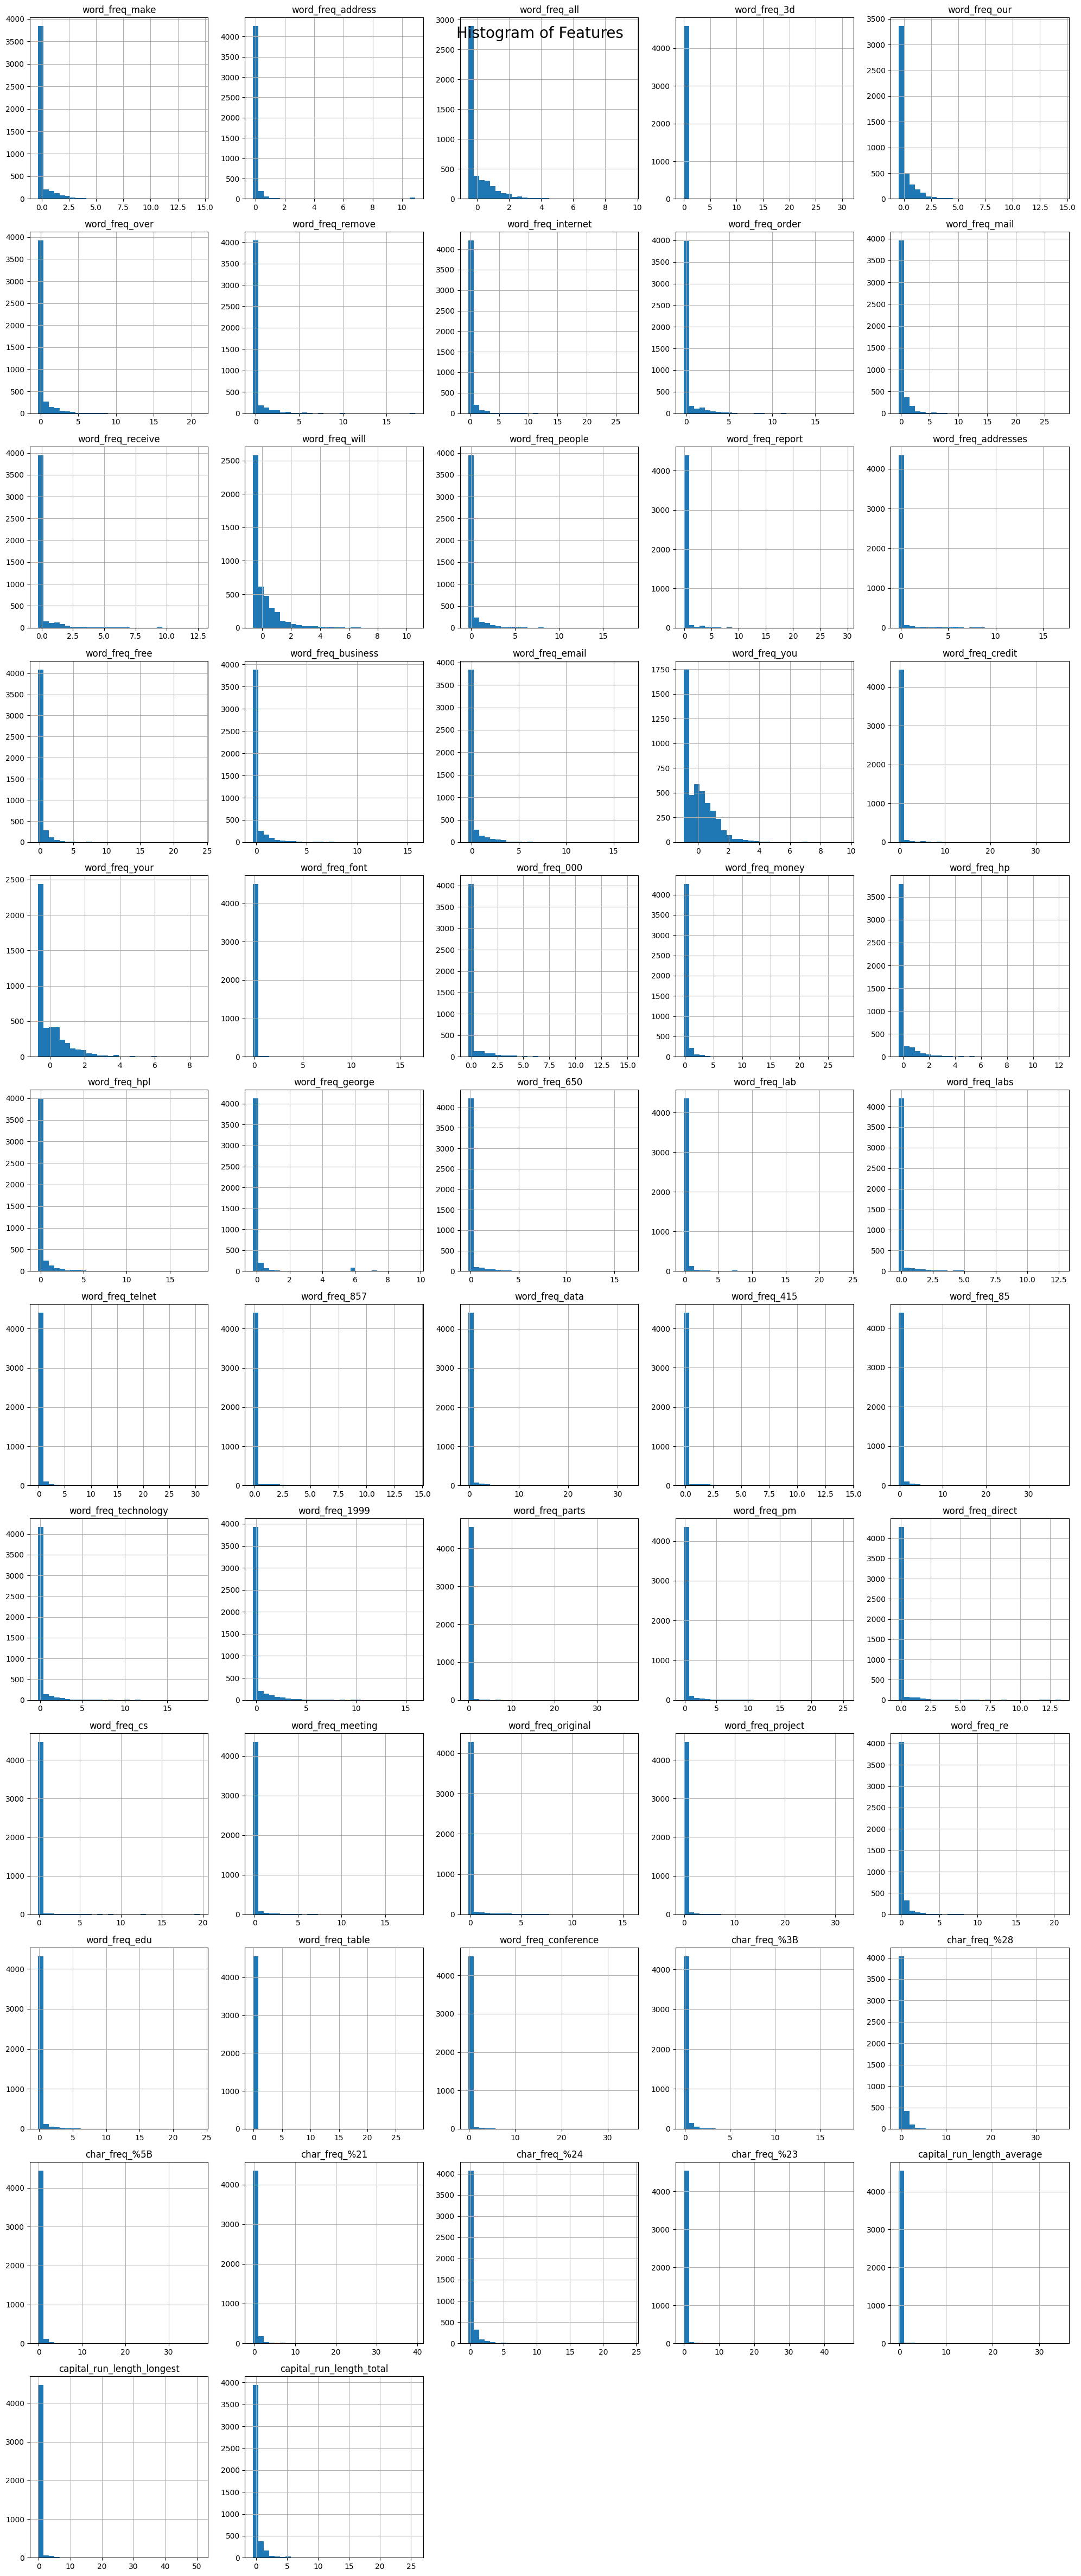

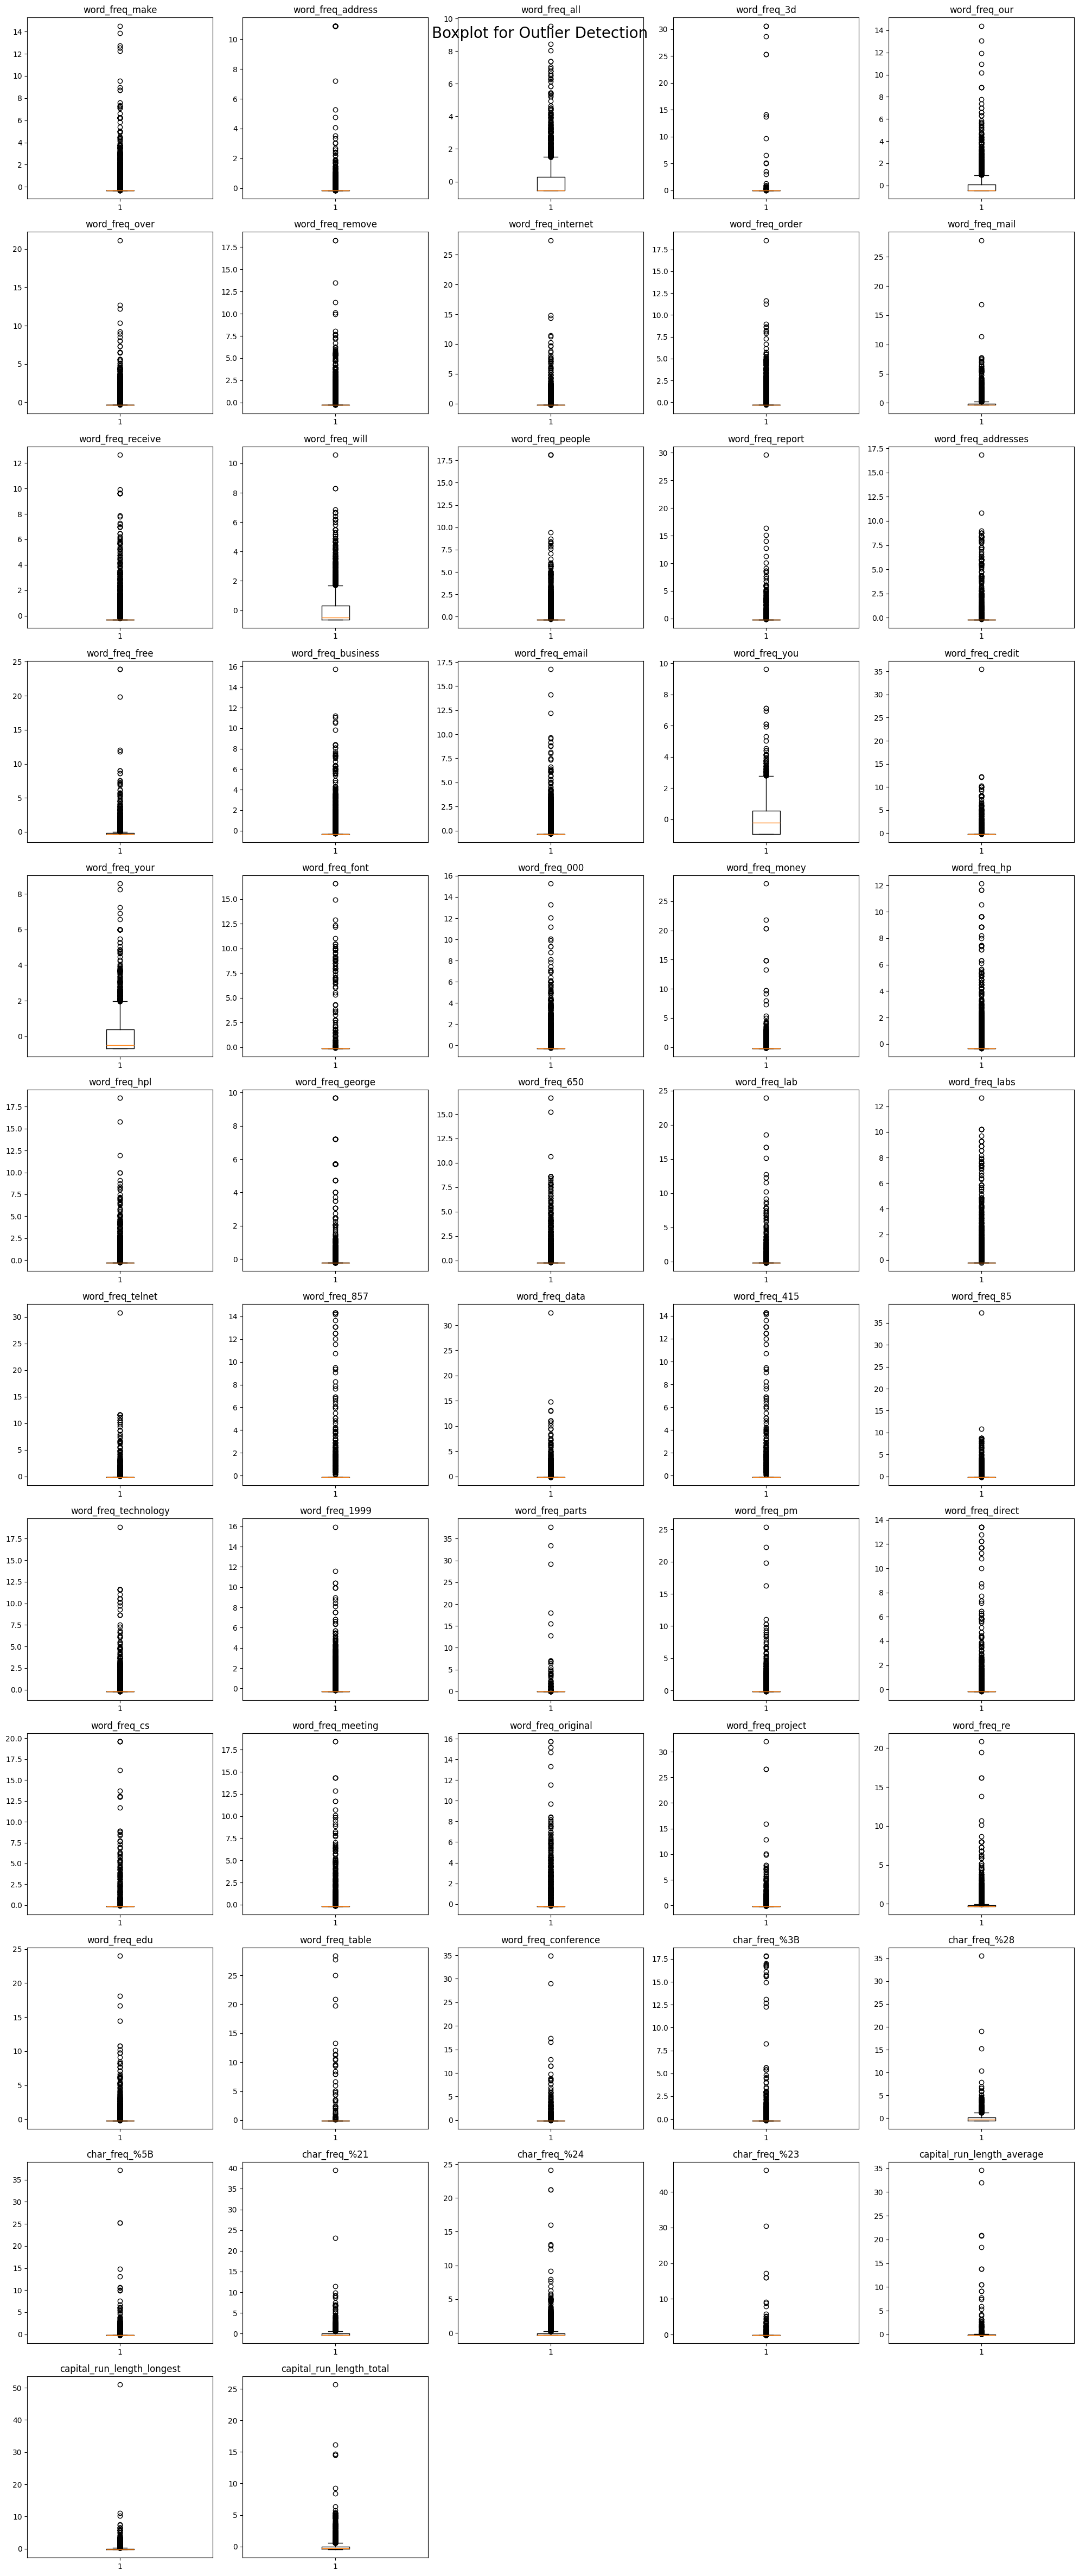

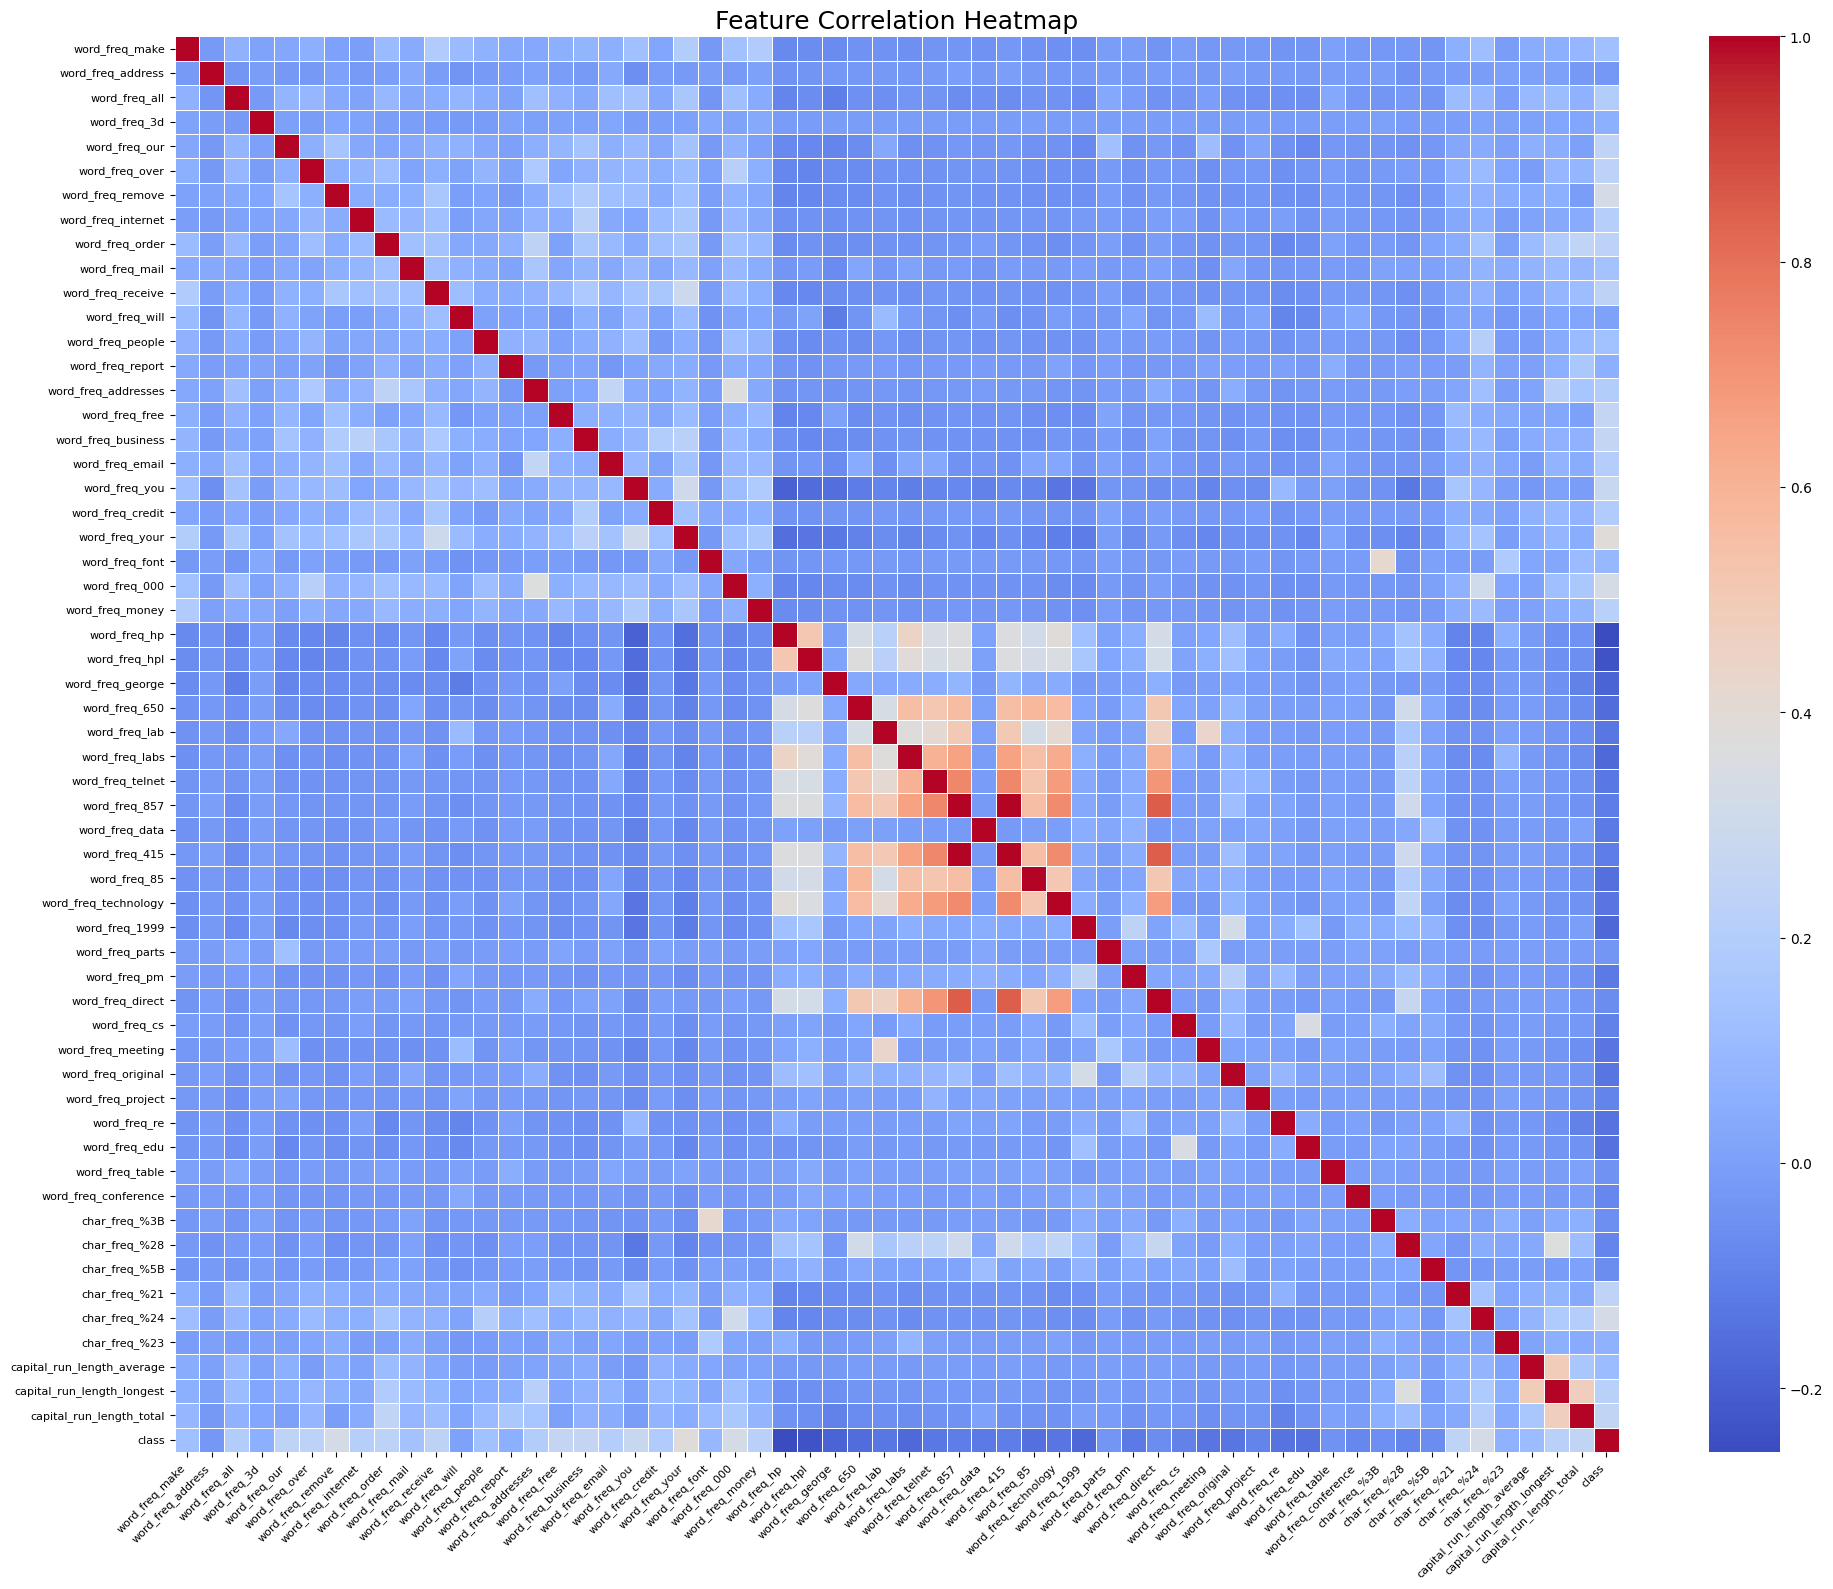

In [ ]:
# --- Histogram Subplots ---
n_cols = 5  # Number of plots per row
n_rows = int(np.ceil(len(numerical_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    df[col].hist(ax=axes[i], bins=30)
    axes[i].set_title(col)

# Turn off unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Histogram of Features", fontsize=20)
plt.tight_layout()
plt.show()

# --- Boxplot Subplots ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    axes[i].boxplot(df[col])
    axes[i].set_title(col)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

fig.suptitle("Boxplot for Outlier Detection", fontsize=20)
plt.tight_layout()
plt.show()

# --- Correlation Heatmap ---
plt.figure(figsize=(20, 16))
sns.heatmap(df.corr(), annot=False, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=18)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# (iv) Splitting dataset

X = df.drop(columns=[target])
y = df[target]

# Splitting: Train (60%), Validation (20%), Test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')

df.to_csv('updated_spam.csv')

Train: (2760, 57), Validation: (920, 57), Test: (921, 57)


In [ ]:
# (v) Model Training

# ---------------- Linear Kernel ----------------
param_grid_l = {'C': [0.1, 1.0, 10]}
grid_l = GridSearchCV(SVC(kernel='linear'), param_grid_l, cv=5)
grid_l.fit(X_train, y_train)

model_l = grid_l.best_estimator_
y_val_pred_l = model_l.predict(X_val)
y_test_pred_l = model_l.predict(X_test)

# ---------------- Polynomial Kernel ----------------
param_grid_p = {
    'C': [0.1, 1.0, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
grid_p = GridSearchCV(SVC(kernel='poly'), param_grid_p, cv=5)
grid_p.fit(X_train, y_train)

model_p = grid_p.best_estimator_
y_val_pred_p = model_p.predict(X_val)
y_test_pred_p = model_p.predict(X_test)

# ---------------- RBF Kernel ----------------
param_grid_r = {
    'C': [0.1, 1.0, 10],
    'gamma': ['scale', 'auto']
}
grid_r = GridSearchCV(SVC(kernel='rbf'), param_grid_r, cv=5)
grid_r.fit(X_train, y_train)

model_r = grid_r.best_estimator_
y_val_pred_r = model_r.predict(X_val)
y_test_pred_r = model_r.predict(X_test)

# ---------------- Sigmoid Kernel ----------------
param_grid_s = {
    'C': [0.1, 1.0, 10],
    'gamma': ['scale', 'auto']
}
grid_s = GridSearchCV(SVC(kernel='sigmoid'), param_grid_s, cv=5)
grid_s.fit(X_train, y_train)

model_s = grid_s.best_estimator_
y_val_pred_s = model_s.predict(X_val)
y_test_pred_s = model_s.predict(X_test)

In [ ]:
# (vi) Evaluation

# Evaluating Model using Performance Metrics

def evaluate_model(y_true, y_pred, is_classification, X, model, dataset_name):
    print(f"\n Evaluation - {dataset_name}")
    if is_classification:
        print("Accuracy :", round(accuracy_score(y_true, y_pred), 4))
        print("Precision:", round(precision_score(y_true, y_pred, average='weighted'), 4))
        print("Recall   :", round(recall_score(y_true, y_pred, average='weighted'), 4))
        print("F1 Score :", round(f1_score(y_true, y_pred, average='weighted'), 4))
        print("\nClassification Report:\n", classification_report(y_true, y_pred))

        # ROC Curve: Only for binary classification
        if len(np.unique(y_true)) == 2 and model is not None and hasattr(model, "predict_proba"):
            y_probs = model.predict_proba(X)[:, 1]
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            auc_score = roc_auc_score(y_true, y_probs)
            print("ROC AUC Score:", round(auc_score, 4))

            # Plot ROC
            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve - {dataset_name}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        n, p = X.shape
        r2 = r2_score(y_true, y_pred)
        adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print("Mean Squared Error:", mean_squared_error(y_true, y_pred))
        print("Root Mean Squared Error:", root_mean_squared_error(y_true, y_pred))
        print("Mean Absolute Error:", mean_absolute_error(y_true, y_pred))
        print("R2 Score:", r2)
        print("Adjusted R2 Score:", adjusted_r2)

evaluate_model(y_val, y_val_pred_l, True, X_val, model_l, "Validation Set - Linear SVM")
evaluate_model(y_test, y_test_pred_l, True, X_test, model_l, "Test Set - Linear SVM")

evaluate_model(y_val, y_val_pred_p, True, X_val, model_p, "Validation Set - Polynomial SVM")
evaluate_model(y_test, y_test_pred_p, True, X_test, model_p, "Test Set - Polynomial SVM")

evaluate_model(y_val, y_val_pred_r, True, X_val, model_r, "Validation Set - RBF SVM")
evaluate_model(y_test, y_test_pred_r, True, X_test, model_r, "Test Set - RBF SVM")

evaluate_model(y_val, y_val_pred_s, True, X_val, model_s, "Validation Set - Sigmoid SVM")
evaluate_model(y_test, y_test_pred_s, True, X_test, model_s, "Test Set - Sigmoid SVM")


 Evaluation - Validation Set - Linear SVM
Accuracy : 0.9348
Precision: 0.9352
Recall   : 0.9348
F1 Score : 0.9344

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       552
           1       0.95      0.89      0.92       368

    accuracy                           0.93       920
   macro avg       0.94      0.93      0.93       920
weighted avg       0.94      0.93      0.93       920


 Evaluation - Test Set - Linear SVM
Accuracy : 0.9229
Precision: 0.923
Recall   : 0.9229
F1 Score : 0.923

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93       537
           1       0.90      0.91      0.91       384

    accuracy                           0.92       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.92      0.92      0.92       921


 Evaluation - Validation Set - Polynomial SVM
Accuracy : 0.9261
Precision

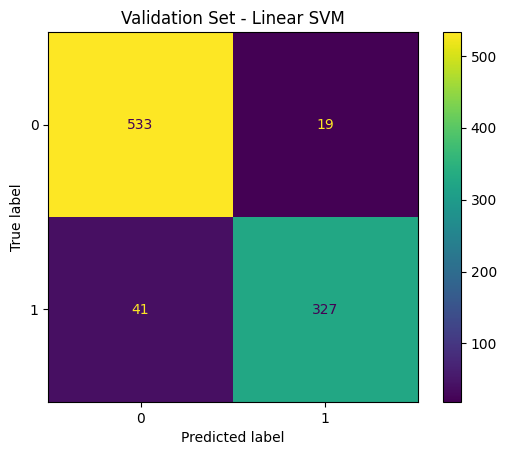

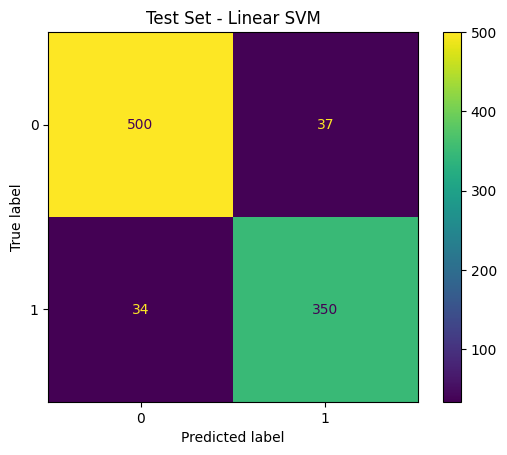

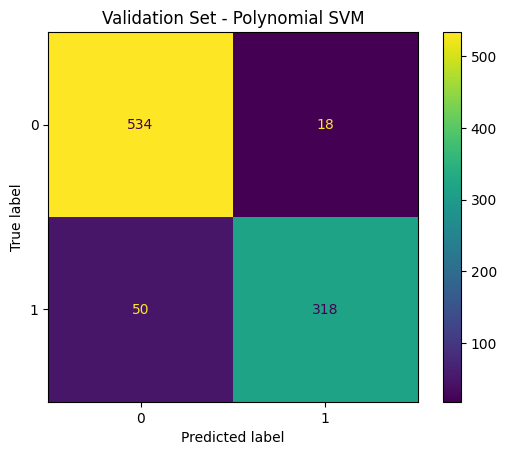

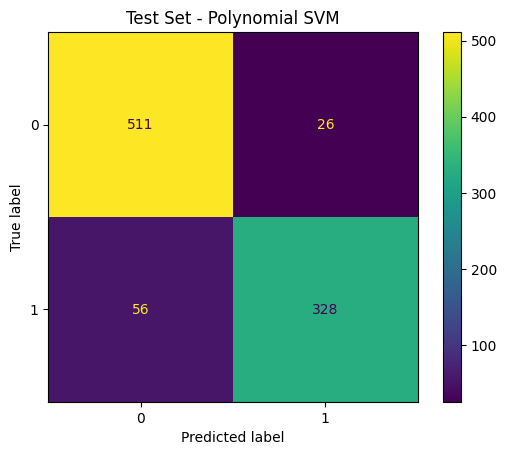

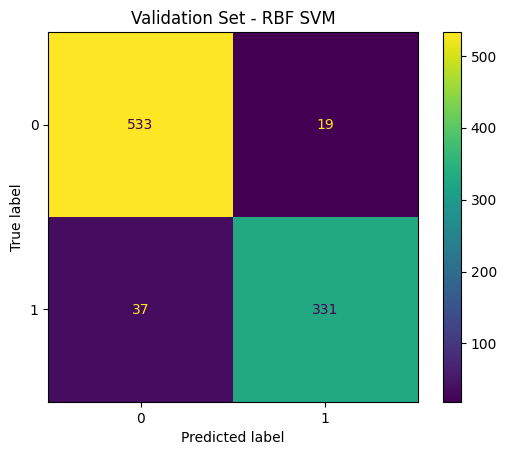

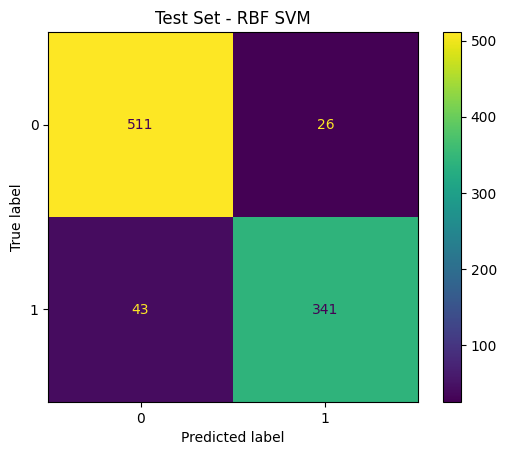

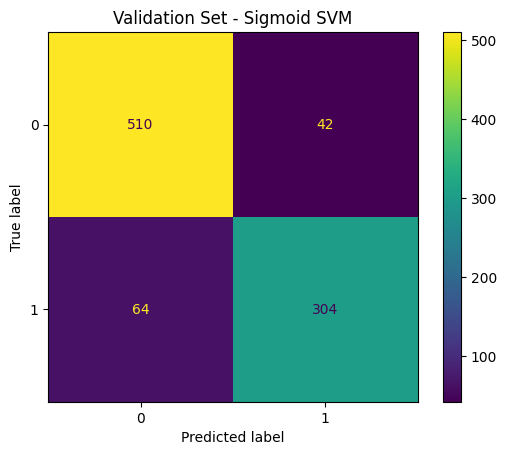

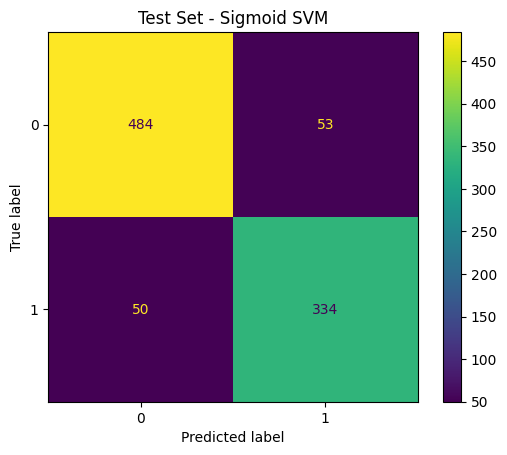

In [ ]:
# Evaluating Model on Test and Validation Sets (Without Performance Metrics)

def plot_actual_vs_predicted(y_true, y_pred, title):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred, residuals, alpha=0.5, edgecolor='k')
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title(f"Residual Plot - {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residual_distribution(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, color='skyblue')
    plt.title(f"Residual Distribution - {title}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, title):
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(title)
    plt.show()

if not is_classification:
  plot_actual_vs_predicted(y_val, y_val_pred, "Validation Set")
  plot_residuals(y_val, y_val_pred, "Validation Set")
  plot_residual_distribution(y_val, y_val_pred, "Validation Set")

  plot_actual_vs_predicted(y_test, y_test_pred, "Test Set")
  plot_residuals(y_test, y_test_pred, "Test Set")
  plot_residual_distribution(y_test, y_test_pred, "Test Set")
else:
  # --- Linear SVM ---
  plot_confusion_matrix(y_val, y_val_pred_l, "Validation Set - Linear SVM")
  plot_confusion_matrix(y_test, y_test_pred_l, "Test Set - Linear SVM")

  # --- Polynomial SVM ---
  plot_confusion_matrix(y_val, y_val_pred_p, "Validation Set - Polynomial SVM")
  plot_confusion_matrix(y_test, y_test_pred_p, "Test Set - Polynomial SVM")

  # --- RBF SVM ---
  plot_confusion_matrix(y_val, y_val_pred_r, "Validation Set - RBF SVM")
  plot_confusion_matrix(y_test, y_test_pred_r, "Test Set - RBF SVM")

  # --- Sigmoid SVM ---
  plot_confusion_matrix(y_val, y_val_pred_s, "Validation Set - Sigmoid SVM")
  plot_confusion_matrix(y_test, y_test_pred_s, "Test Set - Sigmoid SVM")

In [ ]:
# (vii) K-Fold Cross Validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
if is_classification:
    score = 'accuracy'
else:
    score = 'r2'
# --- Linear SVM ---
cv_l = cross_val_score(model_l, X, y, cv=kfold, scoring=score)
print("Linear SVM - CV Scores:", cv_l)
print("Linear SVM - Average CV Score:", np.mean(cv_l))

# --- Polynomial SVM ---
cv_p = cross_val_score(model_p, X, y, cv=kfold, scoring=score)
print("Polynomial SVM - CV Scores:", cv_p)
print("Polynomial SVM - Average CV Score:", np.mean(cv_p))

# --- RBF SVM ---
cv_r = cross_val_score(model_r, X, y, cv=kfold, scoring=score)
print("RBF SVM - CV Scores:", cv_r)
print("RBF SVM - Average CV Score:", np.mean(cv_r))

# --- Sigmoid SVM ---
cv_s = cross_val_score(model_s, X, y, cv=kfold, scoring=score)
print("Sigmoid SVM - CV Scores:", cv_s)
print("Sigmoid SVM - Average CV Score:", np.mean(cv_s))

Linear SVM - CV Scores: [0.92290988 0.92717391 0.92173913 0.93369565 0.93152174]
Linear SVM - Average CV Score: 0.9274080630694426
Polynomial SVM - CV Scores: [0.91856678 0.925      0.91956522 0.91956522 0.91521739]
Polynomial SVM - Average CV Score: 0.9195829202662512
RBF SVM - CV Scores: [0.93485342 0.93369565 0.92282609 0.93586957 0.93043478]
RBF SVM - Average CV Score: 0.9315359014303922
Sigmoid SVM - CV Scores: [0.88599349 0.87282609 0.87826087 0.8923913  0.88804348]
Sigmoid SVM - Average CV Score: 0.8835030448944909


In [ ]:
print("Best params for linear:", grid_l.best_params_)
print("Best params for polynomial:", grid_p.best_params_)
print("Best params for rbf:", grid_r.best_params_)
print("Best params for sigmoid:", grid_s.best_params_)


Best params for linear: {'C': 10}
Best params for polynomial: {'C': 10, 'degree': 2, 'gamma': 'scale'}
Best params for rbf: {'C': 1.0, 'gamma': 'auto'}
Best params for sigmoid: {'C': 1.0, 'gamma': 'auto'}
